In [1]:
import time
import timeit

In [2]:
print('Script started at: ' +  time.strftime('%X %x %Z'))

Script started at: 17:30:01 09/28/23 BST


In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import gridspec
import seaborn as sns
import pingouin as pg
import copy
import pickle
import os

In [4]:
# import shap
# import tensorflow
# print(shap.__version__, "\n",tensorflow.__version__)

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
randomstate = 1234
# For reproducibility
np.random.seed(randomstate)

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [10]:
def save_obj(obj, name, fname ):
    with open(fname+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(fname + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [11]:
import matplotlib.pyplot as plt
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

In [13]:
from itertools import combinations

In [14]:
from matplotlib.colors import LinearSegmentedColormap

In [15]:
label_fontsize = 16 
title_fontsize = 18

In [16]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [17]:
reference = 'neutral' #'neutral','diff'

In [18]:
basefolder = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"

In [19]:
inputfolderpath = basefolder + "drosSleepStages_SciAdvances2023/data/lfp_data/spectrum/forestclassifier/"

In [20]:
datasetpath = inputfolderpath
datasetpath +=  "merged_Spectrum_CSV_" + reference + "_ref" + ".csv"
datasetpath

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/lfp_data/spectrum/forestclassifier/merged_Spectrum_CSV_neutral_ref.csv'

In [21]:
classifierfolderpath = inputfolderpath + "classifier_rf_files/"

In [22]:
def evaluate(model, test_features, test_labels):
    pred_labels = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, pred_labels)
    print('accuracy :',accuracy)
    print(confusion_matrix(test_labels, pred_labels))

In [23]:
def create_rfclassifier(classifierfeat_df, randomstate_testtrainsplit):
      
    classifierdata  = classifierfeat_df.values
    # split into inputs and outputs
    x, y = classifierfeat_df.iloc[:, :-1], classifierfeat_df.iloc[:, -1]
    
    x_sm, y_sm = SMOTE().fit_resample(x, y)
    
    print('before smote :\n',pd.value_counts(y))
    print('after smote :\n',pd.value_counts(y_sm))
    
    # split into train test sets
    x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, stratify=y_sm, 
                                                                random_state=randomstate_testtrainsplit)
    
    #scale the data
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform (x_test)
    
    pd.value_counts(y_train)
    
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)
    
    labels2 = np.argmax(y_train, axis =1)
    pd.value_counts(labels2)
    
    print(encoder.classes_)
    
    #get the mapping for the labels
    mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))

 
    print(encoder.transform(encoder.classes_))
    
    features_len = x_train.shape[1]
    
    num_labels = len(np.unique(y))
    
    #basic random forest classifier..
    model = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, 
                                   min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, 
                                   random_state=randomstate_testtrainsplit)
    model.fit(x_train,y_train)
    #y_pred = model.predict(x_test)
    
    print('\n \n basic random forest classifier with no search')
    evaluate(model, x_test, y_test)

    
    #random forest classifier using random search of parameters..
    print('\n \n best random forest classifier based on random search')
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in range(200,2000,200)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2,
                                   random_state=randomstate_testtrainsplit, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(x_train, y_train)
    
    
    
    print(rf_random.best_params_)
    best_randomgrid = rf_random.best_estimator_
    evaluate(best_randomgrid,x_test,y_test)
    
    #random forest classifier using grid search of choosen parameters..
    print('\n \n best random forest classifier based on refined search on choosen parameters')
    
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'n_estimators': [rf_random.best_params_['n_estimators']],
        'min_samples_split': [rf_random.best_params_['min_samples_split']],
        'min_samples_leaf': [rf_random.best_params_['min_samples_leaf']],
        'max_features': [rf_random.best_params_['max_features']],
        'max_depth': [rf_random.best_params_['max_depth']],
        'bootstrap': [rf_random.best_params_['bootstrap']],
    }
    # Create a based model
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3,
                               n_jobs = -1, verbose = 2)

    # Fit the grid search to the data
    grid_search.fit(x_train,y_train)
    
    print(grid_search.best_params_)
    
    best_grid = grid_search.best_estimator_
    evaluate(best_grid,x_test,y_test)
    
    # Make predictions for the test set
    y_pred = best_grid.predict(x_test)
    
    #create confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    #create performance metrics
    perf_metrics = classification_report(y_test, y_pred, output_dict=True)
    perf_metrics_df = pd.DataFrame(perf_metrics).transpose()
    perf_metrics_df = perf_metrics_df.drop(labels=['accuracy','macro avg','weighted avg'], axis=0)
    perf_metrics_df = perf_metrics_df.drop(columns='support')
    perf_metrics_df = perf_metrics_df.reset_index().rename(columns={'index': 'label'})
    perf_metrics_df['label'] = perf_metrics_df['label'].astype(int)
    perf_metrics_df = perf_metrics_df.replace({'label': mapping})
        
    return encoder, best_grid, x_test, y_test, cnf_matrix, perf_metrics_df 

In [24]:
def rect(pos):
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=2)
    plt.gca().add_patch(r)

In [25]:
def plot_confusion_matrix(cm, classes, fig, ax,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    im = plt.imshow(cm, interpolation='none', cmap=cmap)
    im.set_clim(0, 1.0)
    fig.colorbar(im, ax=ax1, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=14,
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
def compute_featimportance(best_grid_xx, x_test_xx, y_test_xx, randomstate_featimportance, feature_names):
    
    result_xx = permutation_importance(best_grid_xx, x_test_xx, y_test_xx, n_repeats=5, 
                                       random_state=randomstate_featimportance, n_jobs=-1)
    forest_importances_xx = pd.Series(result_xx.importances_mean, index=feature_names)

    forest_importances_df_xx = forest_importances_xx.to_frame().reset_index()
    forest_importances_df_xx = forest_importances_df_xx.rename({'index': 'freqchan', 0: 'value'}, axis=1)
    forest_importances_df_xx['freq'] = forest_importances_df_xx['freqchan'].str.split('_').str[0]
    forest_importances_df_xx['freq2'] = forest_importances_df_xx['freq'].str.split('freq').str[1]
    forest_importances_df_xx['chan'] = forest_importances_df_xx['freqchan'].str.split('_').str[1]
    forest_importances_df_xx['chan2'] = forest_importances_df_xx['chan'].str.split('chan').str[1]

    freqarray_xx = forest_importances_df_xx["freq2"].to_numpy()
    freqarray_xx = freqarray_xx.reshape(145, 15)
    freqarray_xx = freqarray_xx.astype(np.float)


    chanarray_xx = forest_importances_df_xx["chan2"].to_numpy()
    chanarray_xx = chanarray_xx.reshape(145, 15)

    perm_impvalues_xx = forest_importances_df_xx["value"].to_numpy()
    perm_impvalues_xx = perm_impvalues_xx.reshape(145, 15)

    cat_freqs_xx = np.sort(np.unique(freqarray_xx))
    
    return perm_impvalues_xx, freqarray_xx, chanarray_xx, cat_freqs_xx

In [27]:
def plot_spect(data, ax, x, y, x_label, y_label, title, vmin = None, vmax = None, loc = None):
    
    im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
    
    y_mod = y
    freqs_plot = [5, 10, 15, 20, 25, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    
    ytickvals = np.around(y[yticklocs])
    
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    ax.set_xlim([0, np.asarray(x.shape)-1])
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    plt.xticks(xticklocs, tickval)
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=20, labelpad=20)
    ax.set_ylabel(y_label, rotation=90,ha='center',va='center', fontsize=20, labelpad=20)
    
    ax.invert_yaxis()
    
    cbarlabels = np.linspace(vmin, vmax, 5)
    
    if loc is not None:
        cbar = plt.colorbar(im, ax = [ax], ticks = cbarlabels, location = loc)
    else:
        cbar = plt.colorbar(im, ticks = cbarlabels)
      
    cbar.set_ticks(cbarlabels)
    cbar.set_ticklabels(["{:2.4f}".format(i) for i in cbarlabels])
    
    plt.title(title,ha='center',va='bottom', y=1.005, fontsize=20)
    
    cbar.ax.tick_params(labelsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return ax, cbar

In [28]:
def computeclassfeats(compcategories):
    
    classifierfilepath = classifierfolderpath + '_'.join(compcategories) + '_class_iter_01' + '.pkl'
    
    if os.path.exists(classifierfilepath): 
        print('results loaded from disk..')
        encoder_01, best_grid_01, x_test_01, y_test_01, cnf_matrix_01, perf_metrics_df_01 =\
                                  pickle.load(open(classifierfilepath,"rb"))

    else:
        encoder_01, best_grid_01, x_test_01, y_test_01, cnf_matrix_01, perf_metrics_df_01 =\
                                  create_rfclassifier(classifierfeat_df, randomstate_testtrainsplit = 1)
        pickle.dump([encoder_01, best_grid_01, x_test_01, y_test_01, cnf_matrix_01, perf_metrics_df_01], 
                    open(classifierfilepath, "wb"))
        
    classifierfilepath = classifierfolderpath + '_'.join(compcategories) + '_class_iter_02' + '.pkl'
    
    if os.path.exists(classifierfilepath): 
        print('results loaded from disk..')
        encoder_02, best_grid_02, x_test_02, y_test_02, cnf_matrix_02, perf_metrics_df_02 =\
                                  pickle.load(open(classifierfilepath,"rb"))

    else:
        encoder_02, best_grid_02, x_test_02, y_test_02, cnf_matrix_02, perf_metrics_df_02 =\
                                  create_rfclassifier(classifierfeat_df, randomstate_testtrainsplit = 2)
        pickle.dump([encoder_02, best_grid_02, x_test_02, y_test_02, cnf_matrix_02, perf_metrics_df_02], 
                    open(classifierfilepath, "wb")) 
        
        
    classifierfilepath = classifierfolderpath + '_'.join(compcategories) + '_class_iter_03' + '.pkl'
    
    if os.path.exists(classifierfilepath): 
        print('results loaded from disk..')
        encoder_03, best_grid_03, x_test_03, y_test_03, cnf_matrix_03, perf_metrics_df_03 =\
                                  pickle.load(open(classifierfilepath,"rb"))

    else:
        encoder_03, best_grid_03, x_test_03, y_test_03, cnf_matrix_03, perf_metrics_df_03 =\
                                  create_rfclassifier(classifierfeat_df, randomstate_testtrainsplit = 3)
        pickle.dump([encoder_03, best_grid_03, x_test_03, y_test_03, cnf_matrix_03, perf_metrics_df_03], 
                    open(classifierfilepath, "wb"))
        
        
    classifierfilepath = classifierfolderpath + '_'.join(compcategories) + '_class_iter_04' + '.pkl'
    
    if os.path.exists(classifierfilepath): 
        print('results loaded from disk..')
        encoder_04, best_grid_04, x_test_04, y_test_04, cnf_matrix_04, perf_metrics_df_04 =\
                                  pickle.load(open(classifierfilepath,"rb"))

    else:
        encoder_04, best_grid_04, x_test_04, y_test_04, cnf_matrix_04, perf_metrics_df_04 =\
                                  create_rfclassifier(classifierfeat_df, randomstate_testtrainsplit = 4)
        pickle.dump([encoder_04, best_grid_04, x_test_04, y_test_04, cnf_matrix_04, perf_metrics_df_04], 
                    open(classifierfilepath, "wb"))
        
        
    classifierfilepath = classifierfolderpath + '_'.join(compcategories) + '_class_iter_05' + '.pkl'
    
    if os.path.exists(classifierfilepath): 
        print('results loaded from disk..')
        encoder_05, best_grid_05, x_test_05, y_test_05, cnf_matrix_05, perf_metrics_df_05 =\
                                  pickle.load(open(classifierfilepath,"rb"))

    else:
        encoder_05, best_grid_05, x_test_05, y_test_05, cnf_matrix_05, perf_metrics_df_05 =\
                                  create_rfclassifier(classifierfeat_df, randomstate_testtrainsplit = 5)
        pickle.dump([encoder_05, best_grid_05, x_test_05, y_test_05, cnf_matrix_05, perf_metrics_df_05], 
                    open(classifierfilepath, "wb"))
        
        
    for pair in combinations([encoder_01.classes_, encoder_02.classes_, 
                              encoder_03.classes_, encoder_04.classes_,
                              encoder_05.classes_], 2):
        if (np.array_equal(pair[0], pair[1])):
            print('encoder classes are equal')
        else:
            print('encoder classes are not equal')
            
    print('encoder classes : ', encoder_01.classes_)
    
    ordered_index = np.array([1,0])
    ordered_classes = encoder_01.classes_[ordered_index]
    
    print('ordered classes : ', ordered_classes)
    
    ordered_cm_01 = cnf_matrix_01[ordered_index][:,ordered_index]
    ordered_cm_02 = cnf_matrix_02[ordered_index][:,ordered_index]
    ordered_cm_03 = cnf_matrix_03[ordered_index][:,ordered_index]
    ordered_cm_04 = cnf_matrix_04[ordered_index][:,ordered_index]
    ordered_cm_05 = cnf_matrix_05[ordered_index][:,ordered_index]
    
    merged_ordered_cm = np.add.reduce([ordered_cm_01, ordered_cm_02, ordered_cm_03, ordered_cm_04, ordered_cm_05])

    mergedperf_df = pd.concat([perf_metrics_df_01, perf_metrics_df_02, perf_metrics_df_03,
                               perf_metrics_df_04, perf_metrics_df_05])
    
    return mergedperf_df, merged_ordered_cm, ordered_classes

In [29]:
def computepermfeats(compcategories):
    
    permimpfilepath = classifierfolderpath + '_'.join(compcategories) + '_permimp_iter_01' + '.pkl'
    
    if os.path.exists(permimpfilepath): 
        print('results loaded from disk..')
        perm_impvalues_01, freqarray_01, chanarray_01, cat_freqs_01 =\
                                  pickle.load(open(permimpfilepath,"rb"))

    else:
        perm_impvalues_01, freqarray_01, chanarray_01, cat_freqs_01 =\
                compute_featimportance(best_grid_01, x_test_01, y_test_01, 1, feature_names)
        pickle.dump([perm_impvalues_01, freqarray_01, chanarray_01, cat_freqs_01], 
                    open(permimpfilepath, "wb"))
        
        
    permimpfilepath = classifierfolderpath + '_'.join(compcategories) + '_permimp_iter_02' + '.pkl'
    
    if os.path.exists(permimpfilepath): 
        print('results loaded from disk..')
        perm_impvalues_02, freqarray_02, chanarray_02, cat_freqs_02 =\
                                  pickle.load(open(permimpfilepath,"rb"))

    else:
        perm_impvalues_02, freqarray_02, chanarray_02, cat_freqs_02 =\
                compute_featimportance(best_grid_02, x_test_02, y_test_02, 2, feature_names)
        pickle.dump([perm_impvalues_02, freqarray_02, chanarray_02, cat_freqs_02], 
                    open(permimpfilepath, "wb"))
        
        
    permimpfilepath = classifierfolderpath + '_'.join(compcategories) + '_permimp_iter_03' + '.pkl'
    
    if os.path.exists(permimpfilepath): 
        print('results loaded from disk..')
        perm_impvalues_03, freqarray_03, chanarray_03, cat_freqs_03 =\
                                  pickle.load(open(permimpfilepath,"rb"))

    else:
        perm_impvalues_03, freqarray_03, chanarray_03, cat_freqs_03 =\
                compute_featimportance(best_grid_03, x_test_03, y_test_03, 3, feature_names)
        pickle.dump([perm_impvalues_03, freqarray_03, chanarray_03, cat_freqs_03], 
                    open(permimpfilepath, "wb"))
        
        
    permimpfilepath = classifierfolderpath + '_'.join(compcategories) + '_permimp_iter_04' + '.pkl'
    
    if os.path.exists(permimpfilepath): 
        print('results loaded from disk..')
        perm_impvalues_04, freqarray_04, chanarray_04, cat_freqs_04 =\
                                  pickle.load(open(permimpfilepath,"rb"))

    else:
        perm_impvalues_04, freqarray_04, chanarray_04, cat_freqs_04 =\
                compute_featimportance(best_grid_04, x_test_04, y_test_04, 4, feature_names)
        pickle.dump([perm_impvalues_04, freqarray_04, chanarray_04, cat_freqs_04], 
                    open(permimpfilepath, "wb"))
        
        
    permimpfilepath = classifierfolderpath + '_'.join(compcategories) + '_permimp_iter_05' + '.pkl'
    
    if os.path.exists(permimpfilepath): 
        print('results loaded from disk..')
        perm_impvalues_05, freqarray_05, chanarray_05, cat_freqs_05 =\
                                  pickle.load(open(permimpfilepath,"rb"))

    else:
        perm_impvalues_05, freqarray_05, chanarray_05, cat_freqs_05 =\
                compute_featimportance(best_grid_05, x_test_05, y_test_05, 5, feature_names)
        pickle.dump([perm_impvalues_05, freqarray_05, chanarray_05, cat_freqs_05], 
                    open(permimpfilepath, "wb"))
        
        
    merged_perm_impvalues = np.mean(np.array([perm_impvalues_01, perm_impvalues_02, perm_impvalues_03, 
                                          perm_impvalues_04, perm_impvalues_05]), axis=0 )
    
    return merged_perm_impvalues, cat_freqs_01

In [30]:
# We have training data available as csv file
features_df = pd.read_csv(datasetpath)

In [31]:
features_df

,freq4.88_chan01,freq4.88_chan02,freq4.88_chan03,freq4.88_chan04,freq4.88_chan05,freq4.88_chan06,freq4.88_chan07,freq4.88_chan08,freq4.88_chan09,freq4.88_chan10,...,freq40.04_chan11,freq40.04_chan12,freq40.04_chan13,freq40.04_chan14,freq40.04_chan15,start_time,end_time,state,depth,fly
0,16.907746,18.031327,16.695582,16.928798,15.740280,13.882950,12.989385,13.230149,12.057229,12.278152,...,3.228627,-0.163291,3.477128,5.864448,10.546624,27-Jul-2018 15:13:17,27-Jul-2018 15:49:01,awake,epoch01_depth35_min01,27072018_SponSleep_LFP
1,18.219623,17.288638,14.989972,14.163098,13.005335,11.676813,10.656620,9.535862,8.410238,8.727287,...,2.609511,-2.032236,0.119382,-0.759690,1.761731,27-Jul-2018 15:13:17,27-Jul-2018 15:49:01,awake,epoch01_depth35_min02,27072018_SponSleep_LFP
2,19.019229,18.067138,16.807576,16.786777,16.122223,15.413145,15.789958,13.978603,13.332066,12.588074,...,8.372123,3.774294,9.054524,11.292854,15.218561,27-Jul-2018 15:13:17,27-Jul-2018 15:49:01,awake,epoch01_depth35_min03,27072018_SponSleep_LFP
3,17.412197,15.146518,13.969461,13.137674,12.669202,12.023402,10.728541,10.636679,9.142379,8.341223,...,1.538661,-2.308884,-1.166614,0.845271,0.130059,27-Jul-2018 15:13:17,27-Jul-2018 15:49:01,awake,epoch01_depth35_min04,27072018_SponSleep_LFP
4,16.852660,15.657018,15.303795,15.510230,15.219867,14.411664,14.829397,14.049612,12.047110,12.566136,...,9.052597,2.516190,11.085336,13.465725,17.404638,27-Jul-2018 15:13:17,27-Jul-2018 15:49:01,awake,epoch01_depth35_min05,27072018_SponSleep_LFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9216,5.384316,4.520180,4.416598,4.200604,2.423884,1.408764,2.341573,1.330297,2.545163,-0.069842,...,-4.562900,-4.254393,-5.182509,-3.241753,-4.578022,13-Mar-2019 17:33:19,13-Mar-2019 17:42:41,latesleep,epoch04_depth01_min01,13032019_SponSleep_LFP
9217,7.748099,7.314080,7.430064,6.268098,4.917377,3.943951,3.213651,3.149770,3.304940,1.394683,...,-5.201816,-4.321264,-4.879158,-3.198854,-2.762537,13-Mar-2019 17:52:00,13-Mar-2019 17:59:11,latesleep,epoch05_depth01_min01,13032019_SponSleep_LFP
9218,6.214232,6.497935,6.618647,5.300278,3.599756,3.440659,3.094485,1.248967,3.086514,0.598200,...,-5.215729,-4.615625,-5.367402,-4.736421,-4.348551,13-Mar-2019 18:10:50,13-Mar-2019 18:17:43,latesleep,epoch06_depth01_min01,13032019_SponSleep_LFP
9219,6.656751,6.654786,6.809023,5.737107,5.398233,4.580573,3.932749,4.273100,3.936683,1.769453,...,-5.705252,-5.420793,-4.880630,-3.688537,-3.957618,13-Mar-2019 18:30:59,13-Mar-2019 18:47:09,latesleep,epoch07_depth01_min01,13032019_SponSleep_LFP


In [32]:
features_df['state'] = features_df['state'].str.replace('intrans', 'presleep')
features_df['state'] = features_df['state'].str.replace('earlymidsleep', 'earlysleep')
features_df['state'] = features_df['state'].str.replace('latemidsleep', 'latesleep')

In [33]:
features_df['state'].value_counts()

awake         5585
sleep         1689
midsleep      1165
earlysleep     262
latesleep      262
presleep       258
Name: state, dtype: int64

## awake vs sleep

In [34]:
compcategories = ['awake', 'sleep']

#['awake', 'sleep'] -- good perf, useful
#['presleep', 'earlysleep'] -- ok perf, useful
#['earlysleep', 'midsleep'] -- good perf, useful
#['latesleep', 'midsleep'] -- good perf, useful
#['earlysleep', 'latesleep'] -- bad perf, useful

In [35]:
features_df2 = features_df[features_df['state'].isin(compcategories)]
label_names = features_df2.state
classifierfeat_df = features_df2.copy()
classifierfeat_df = classifierfeat_df.drop(['start_time','end_time','depth','fly'], axis=1)

In [36]:
mergedperf_df, merged_ordered_cm, ordered_classes = computeclassfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes :  ['awake' 'sleep']
ordered classes :  ['sleep' 'awake']


In [37]:
mergedperf_df

,label,precision,recall,f1-score
0,awake,0.980769,0.913160,0.945758
1,sleep,0.918760,0.982095,0.949373
0,awake,0.979008,0.918532,0.947806
1,sleep,0.923272,0.980304,0.950934
0,awake,0.986408,0.909579,0.946437
1,sleep,0.916113,0.987466,0.950452
0,awake,0.984689,0.921218,0.951896
1,sleep,0.925988,0.985676,0.954900
0,awake,0.976258,0.920322,0.947465
1,sleep,0.924640,0.977619,0.950392


In [38]:
color_dict = dict({'awake':'#b34d4d',
                   'presleep':'#f2ad0d',
                   'earlysleep':'#1ac1e6',
                   'midsleep':'#0d28f2',
                   'latesleep':'#b3714d',
                   'sleep':'#0D28F2'
                  })

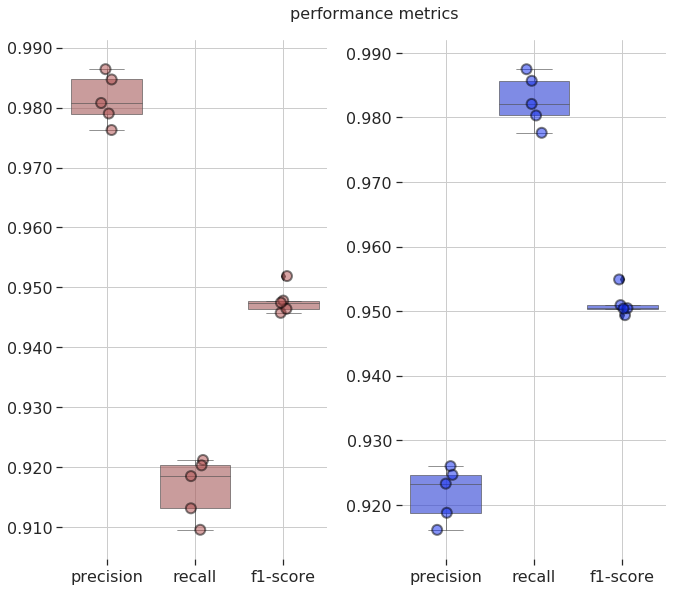

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24*2/5, 8))
fig.subplots_adjust(wspace=0.35, hspace=0.15)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, 
            color = color_dict[compcategories[0]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[0]], alpha = 0.5)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, 
            color = color_dict[compcategories[1]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[1]], alpha = 0.5)

sns.despine(left=True, bottom = True)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)


ax1.grid(True)
ax2.grid(True)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))


ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.suptitle('performance metrics\n', x=0.55, y = 1.025, fontsize=label_fontsize)
plt.tight_layout()

In [40]:
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'lime'])

Normalized confusion matrix


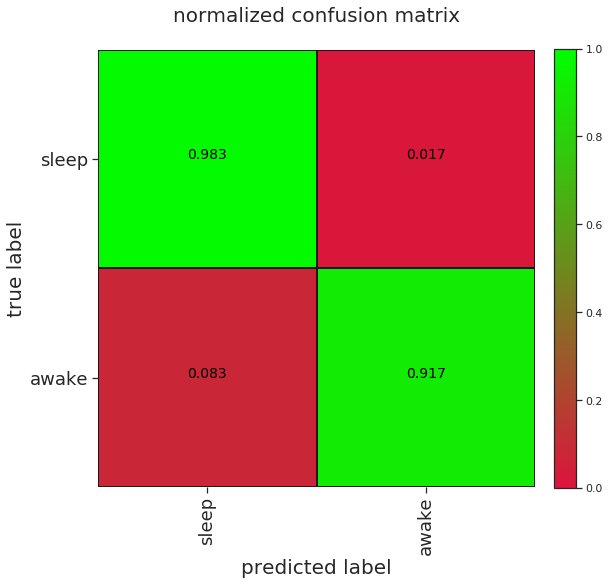

In [41]:
# Plot normalized confusion matrix
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(8, 8))

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(merged_ordered_cm, classes=np.asarray(ordered_classes), 
                      fig = f, ax = ax1,cmap=cmap,
                      normalize=True)
a = (merged_ordered_cm*0)+1
x,y = np.meshgrid(np.arange(a.shape[1]),np.arange(a.shape[0]))
m = np.c_[x[a.astype(bool)],y[a.astype(bool)]]
for pos in m:
    rect(pos)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.set_ylabel('true label', fontsize=label_fontsize+4)
ax1.set_xlabel('predicted label', fontsize=label_fontsize+4)
ax1.set_title('normalized confusion matrix\n', fontsize=label_fontsize+4)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize+2)
ax1.grid(False)
plt.box(False)

In [42]:
feature_names = classifierfeat_df.columns[:-1]
feature_names

Index(['freq4.88_chan01', 'freq4.88_chan02', 'freq4.88_chan03',
       'freq4.88_chan04', 'freq4.88_chan05', 'freq4.88_chan06',
       'freq4.88_chan07', 'freq4.88_chan08', 'freq4.88_chan09',
       'freq4.88_chan10',
       ...
       'freq40.04_chan06', 'freq40.04_chan07', 'freq40.04_chan08',
       'freq40.04_chan09', 'freq40.04_chan10', 'freq40.04_chan11',
       'freq40.04_chan12', 'freq40.04_chan13', 'freq40.04_chan14',
       'freq40.04_chan15'],
      dtype='object', length=2175)

In [43]:
merged_perm_impvalues, cat_freqs_01 = computepermfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..


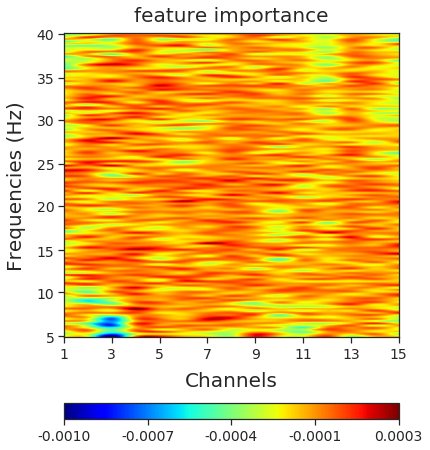

In [44]:
fig = plt.figure(figsize=(6, 8))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])

ax1, cbar1 = plot_spect(merged_perm_impvalues, ax = ax1, x = np.arange(0,15), y = cat_freqs_01, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)' , title = 'feature importance',
                 vmin = np.round(np.min(merged_perm_impvalues),5), 
                 vmax = np.round(np.max(merged_perm_impvalues),5), loc = 'bottom')

## presleep vs earlysleep

In [45]:
compcategories = ['presleep', 'earlysleep']

#['awake', 'sleep'] -- good perf, useful
#['presleep', 'earlysleep'] -- ok perf, useful
#['earlysleep', 'midsleep'] -- good perf, useful
#['latesleep', 'midsleep'] -- good perf, useful
#['earlysleep', 'latesleep'] -- bad perf, useful

In [46]:
features_df2 = features_df[features_df['state'].isin(compcategories)]
label_names = features_df2.state
classifierfeat_df = features_df2.copy()
classifierfeat_df = classifierfeat_df.drop(['start_time','end_time','depth','fly'], axis=1)

In [47]:
mergedperf_df, merged_ordered_cm, ordered_classes = computeclassfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes :  ['earlysleep' 'presleep']
ordered classes :  ['presleep' 'earlysleep']


In [48]:
mergedperf_df

,label,precision,recall,f1-score
0,earlysleep,0.661538,0.826923,0.735043
1,presleep,0.775000,0.584906,0.666667
0,earlysleep,0.716981,0.716981,0.716981
1,presleep,0.711538,0.711538,0.711538
0,earlysleep,0.692308,0.679245,0.685714
1,presleep,0.679245,0.692308,0.685714
0,earlysleep,0.766667,0.867925,0.814159
1,presleep,0.844444,0.730769,0.783505
0,earlysleep,0.632653,0.596154,0.613861
1,presleep,0.625000,0.660377,0.642202


In [49]:
color_dict = dict({'awake':'#b34d4d',
                   'presleep':'#f2ad0d',
                   'earlysleep':'#1ac1e6',
                   'midsleep':'#0d28f2',
                   'latesleep':'#b3714d',
                   'sleep':'#0D28F2'
                  })

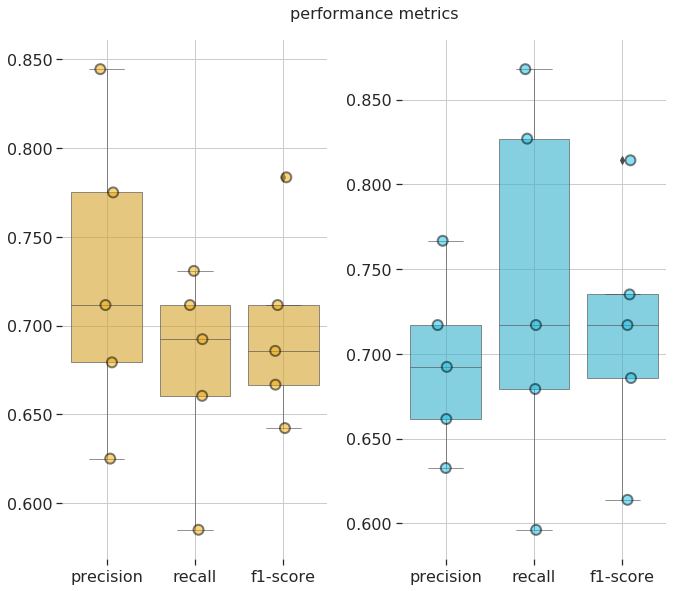

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24*2/5, 8))
fig.subplots_adjust(wspace=0.35, hspace=0.15)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, 
            color = color_dict[compcategories[0]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[0]], alpha = 0.5)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, 
            color = color_dict[compcategories[1]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[1]], alpha = 0.5)

sns.despine(left=True, bottom = True)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)


ax1.grid(True)
ax2.grid(True)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))


ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.suptitle('performance metrics\n', x=0.55, y = 1.025, fontsize=label_fontsize)
plt.tight_layout()

In [51]:
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'lime'])

Normalized confusion matrix


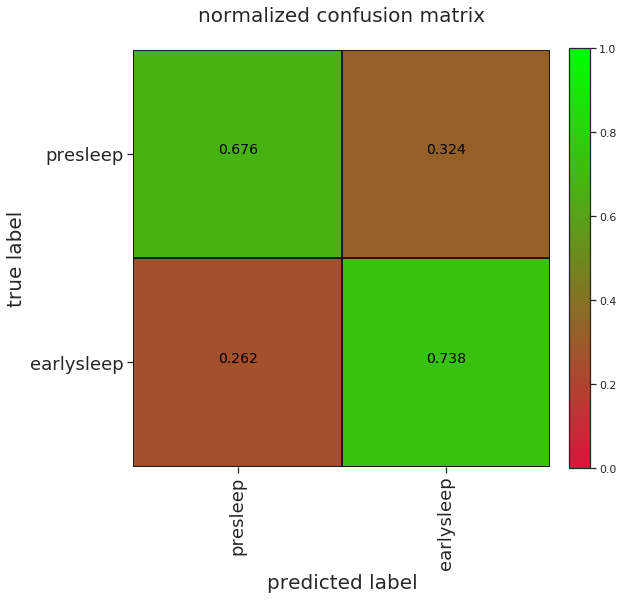

In [52]:
# Plot normalized confusion matrix
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(8, 8))

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(merged_ordered_cm, classes=np.asarray(ordered_classes), 
                      fig = f, ax = ax1,cmap=cmap,
                      normalize=True)
a = (merged_ordered_cm*0)+1
x,y = np.meshgrid(np.arange(a.shape[1]),np.arange(a.shape[0]))
m = np.c_[x[a.astype(bool)],y[a.astype(bool)]]
for pos in m:
    rect(pos)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.set_ylabel('true label', fontsize=label_fontsize+4)
ax1.set_xlabel('predicted label', fontsize=label_fontsize+4)
ax1.set_title('normalized confusion matrix\n', fontsize=label_fontsize+4)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize+2)
ax1.grid(False)
plt.box(False)

In [53]:
feature_names = classifierfeat_df.columns[:-1]
feature_names

Index(['freq4.88_chan01', 'freq4.88_chan02', 'freq4.88_chan03',
       'freq4.88_chan04', 'freq4.88_chan05', 'freq4.88_chan06',
       'freq4.88_chan07', 'freq4.88_chan08', 'freq4.88_chan09',
       'freq4.88_chan10',
       ...
       'freq40.04_chan06', 'freq40.04_chan07', 'freq40.04_chan08',
       'freq40.04_chan09', 'freq40.04_chan10', 'freq40.04_chan11',
       'freq40.04_chan12', 'freq40.04_chan13', 'freq40.04_chan14',
       'freq40.04_chan15'],
      dtype='object', length=2175)

In [54]:
merged_perm_impvalues, cat_freqs_01 = computepermfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..


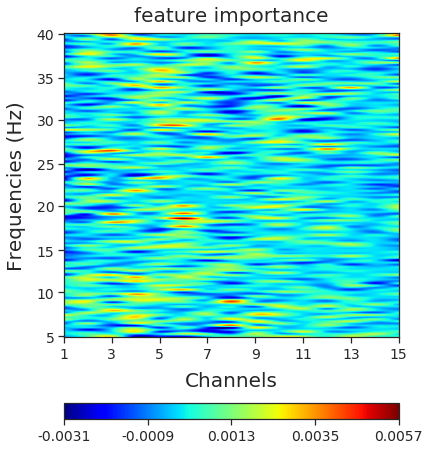

In [55]:
fig = plt.figure(figsize=(6, 8))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])

ax1, cbar1 = plot_spect(merged_perm_impvalues, ax = ax1, x = np.arange(0,15), y = cat_freqs_01, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)' , title = 'feature importance',
                 vmin = np.round(np.min(merged_perm_impvalues),5), 
                 vmax = np.round(np.max(merged_perm_impvalues),5), loc = 'bottom')

## earlysleep vs midsleep

In [56]:
compcategories = ['earlysleep', 'midsleep']

#['awake', 'sleep'] -- good perf, useful
#['presleep', 'earlysleep'] -- ok perf, useful
#['earlysleep', 'midsleep'] -- good perf, useful
#['latesleep', 'midsleep'] -- good perf, useful
#['earlysleep', 'latesleep'] -- bad perf, useful

In [57]:
features_df2 = features_df[features_df['state'].isin(compcategories)]
label_names = features_df2.state
classifierfeat_df = features_df2.copy()
classifierfeat_df = classifierfeat_df.drop(['start_time','end_time','depth','fly'], axis=1)

In [58]:
mergedperf_df, merged_ordered_cm, ordered_classes = computeclassfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes :  ['earlysleep' 'midsleep']
ordered classes :  ['midsleep' 'earlysleep']


In [59]:
mergedperf_df

,label,precision,recall,f1-score
0,earlysleep,0.978448,0.974249,0.976344
1,midsleep,0.974359,0.978541,0.976445
0,earlysleep,0.941909,0.974249,0.957806
1,midsleep,0.973333,0.939914,0.956332
0,earlysleep,0.970464,0.987124,0.978723
1,midsleep,0.986900,0.969957,0.978355
0,earlysleep,0.950413,0.987124,0.968421
1,midsleep,0.986607,0.948498,0.967177
0,earlysleep,0.965368,0.957082,0.961207
1,midsleep,0.957447,0.965665,0.961538


In [60]:
color_dict = dict({'awake':'#b34d4d',
                   'presleep':'#f2ad0d',
                   'earlysleep':'#1ac1e6',
                   'midsleep':'#0d28f2',
                   'latesleep':'#b3714d',
                   'sleep':'#0D28F2'
                  })

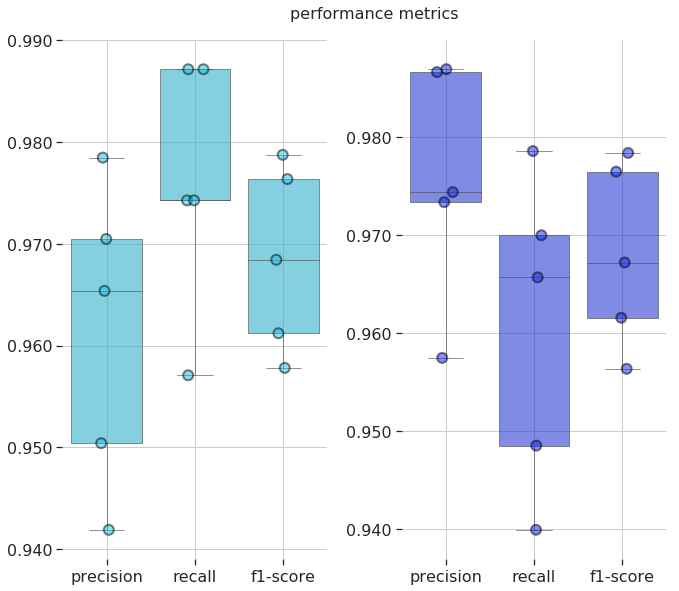

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24*2/5, 8))
fig.subplots_adjust(wspace=0.35, hspace=0.15)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, 
            color = color_dict[compcategories[0]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[0]], alpha = 0.5)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, 
            color = color_dict[compcategories[1]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[1]], alpha = 0.5)

sns.despine(left=True, bottom = True)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)


ax1.grid(True)
ax2.grid(True)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))


ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.suptitle('performance metrics\n', x=0.55, y = 1.025, fontsize=label_fontsize)
plt.tight_layout()

In [62]:
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'lime'])

Normalized confusion matrix


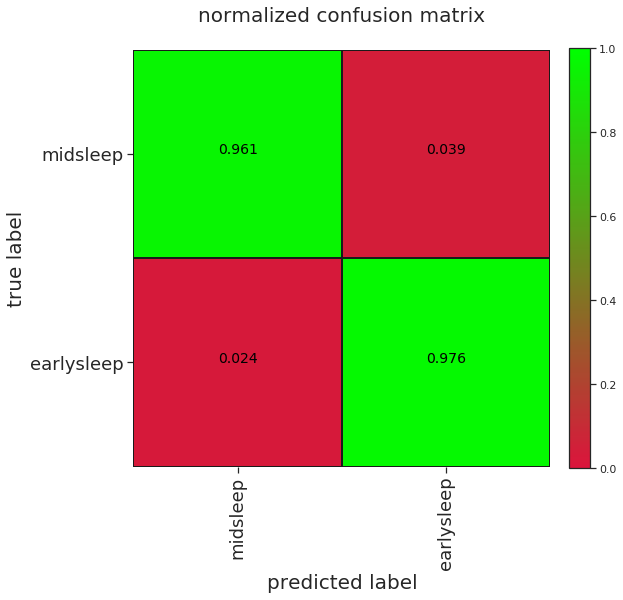

In [63]:
# Plot normalized confusion matrix
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(8, 8))

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(merged_ordered_cm, classes=np.asarray(ordered_classes), 
                      fig = f, ax = ax1,cmap=cmap,
                      normalize=True)
a = (merged_ordered_cm*0)+1
x,y = np.meshgrid(np.arange(a.shape[1]),np.arange(a.shape[0]))
m = np.c_[x[a.astype(bool)],y[a.astype(bool)]]
for pos in m:
    rect(pos)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.set_ylabel('true label', fontsize=label_fontsize+4)
ax1.set_xlabel('predicted label', fontsize=label_fontsize+4)
ax1.set_title('normalized confusion matrix\n', fontsize=label_fontsize+4)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize+2)
ax1.grid(False)
plt.box(False)

In [64]:
feature_names = classifierfeat_df.columns[:-1]
feature_names

Index(['freq4.88_chan01', 'freq4.88_chan02', 'freq4.88_chan03',
       'freq4.88_chan04', 'freq4.88_chan05', 'freq4.88_chan06',
       'freq4.88_chan07', 'freq4.88_chan08', 'freq4.88_chan09',
       'freq4.88_chan10',
       ...
       'freq40.04_chan06', 'freq40.04_chan07', 'freq40.04_chan08',
       'freq40.04_chan09', 'freq40.04_chan10', 'freq40.04_chan11',
       'freq40.04_chan12', 'freq40.04_chan13', 'freq40.04_chan14',
       'freq40.04_chan15'],
      dtype='object', length=2175)

In [65]:
merged_perm_impvalues, cat_freqs_01 = computepermfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..


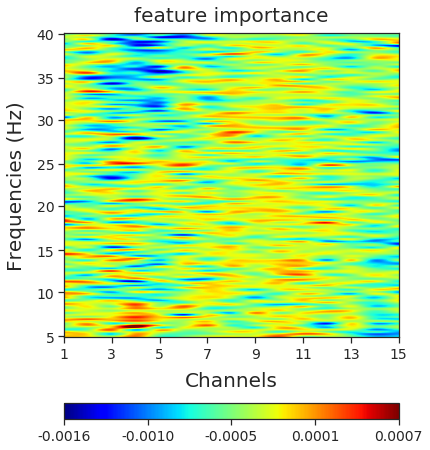

In [66]:
fig = plt.figure(figsize=(6, 8))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])

ax1, cbar1 = plot_spect(merged_perm_impvalues, ax = ax1, x = np.arange(0,15), y = cat_freqs_01, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)' , title = 'feature importance',
                 vmin = np.round(np.min(merged_perm_impvalues),5), 
                 vmax = np.round(np.max(merged_perm_impvalues),5), loc = 'bottom')

## latesleep vs midsleep

In [67]:
compcategories = ['latesleep', 'midsleep']

#['awake', 'sleep'] -- good perf, useful
#['presleep', 'earlysleep'] -- ok perf, useful
#['earlysleep', 'midsleep'] -- good perf, useful
#['latesleep', 'midsleep'] -- good perf, useful
#['earlysleep', 'latesleep'] -- bad perf, useful

In [68]:
features_df2 = features_df[features_df['state'].isin(compcategories)]
label_names = features_df2.state
classifierfeat_df = features_df2.copy()
classifierfeat_df = classifierfeat_df.drop(['start_time','end_time','depth','fly'], axis=1)

In [69]:
mergedperf_df, merged_ordered_cm, ordered_classes = computeclassfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes :  ['latesleep' 'midsleep']
ordered classes :  ['midsleep' 'latesleep']


In [70]:
mergedperf_df

,label,precision,recall,f1-score
0,latesleep,0.961702,0.969957,0.965812
1,midsleep,0.969697,0.961373,0.965517
0,latesleep,0.961207,0.957082,0.959140
1,midsleep,0.957265,0.961373,0.959315
0,latesleep,0.978632,0.982833,0.980728
1,midsleep,0.982759,0.978541,0.980645
0,latesleep,0.974468,0.982833,0.978632
1,midsleep,0.982684,0.974249,0.978448
0,latesleep,0.939655,0.935622,0.937634
1,midsleep,0.935897,0.939914,0.937901


In [71]:
color_dict = dict({'awake':'#b34d4d',
                   'presleep':'#f2ad0d',
                   'earlysleep':'#1ac1e6',
                   'midsleep':'#0d28f2',
                   'latesleep':'#b3714d',
                   'sleep':'#0D28F2'
                  })

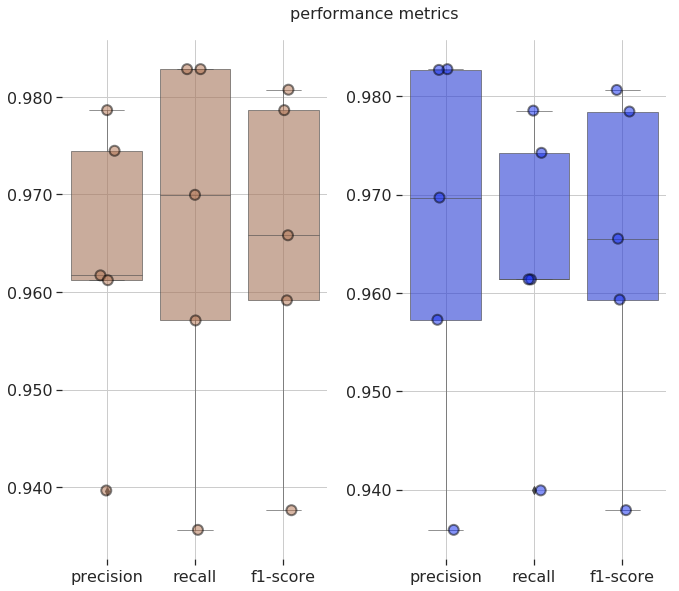

In [72]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24*2/5, 8))
fig.subplots_adjust(wspace=0.35, hspace=0.15)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, 
            color = color_dict[compcategories[0]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[0]], alpha = 0.5)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, 
            color = color_dict[compcategories[1]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[1]], alpha = 0.5)

sns.despine(left=True, bottom = True)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)


ax1.grid(True)
ax2.grid(True)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))


ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.suptitle('performance metrics\n', x=0.55, y = 1.025, fontsize=label_fontsize)
plt.tight_layout()

In [73]:
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'lime'])

Normalized confusion matrix


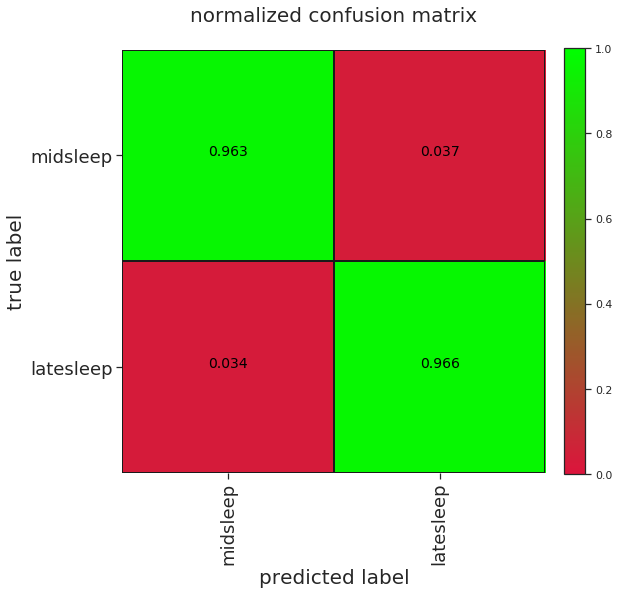

In [74]:
# Plot normalized confusion matrix
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(8, 8))

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(merged_ordered_cm, classes=np.asarray(ordered_classes), 
                      fig = f, ax = ax1,cmap=cmap,
                      normalize=True)
a = (merged_ordered_cm*0)+1
x,y = np.meshgrid(np.arange(a.shape[1]),np.arange(a.shape[0]))
m = np.c_[x[a.astype(bool)],y[a.astype(bool)]]
for pos in m:
    rect(pos)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.set_ylabel('true label', fontsize=label_fontsize+4)
ax1.set_xlabel('predicted label', fontsize=label_fontsize+4)
ax1.set_title('normalized confusion matrix\n', fontsize=label_fontsize+4)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize+2)
ax1.grid(False)
plt.box(False)

In [75]:
feature_names = classifierfeat_df.columns[:-1]
feature_names

Index(['freq4.88_chan01', 'freq4.88_chan02', 'freq4.88_chan03',
       'freq4.88_chan04', 'freq4.88_chan05', 'freq4.88_chan06',
       'freq4.88_chan07', 'freq4.88_chan08', 'freq4.88_chan09',
       'freq4.88_chan10',
       ...
       'freq40.04_chan06', 'freq40.04_chan07', 'freq40.04_chan08',
       'freq40.04_chan09', 'freq40.04_chan10', 'freq40.04_chan11',
       'freq40.04_chan12', 'freq40.04_chan13', 'freq40.04_chan14',
       'freq40.04_chan15'],
      dtype='object', length=2175)

In [76]:
merged_perm_impvalues, cat_freqs_01 = computepermfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..


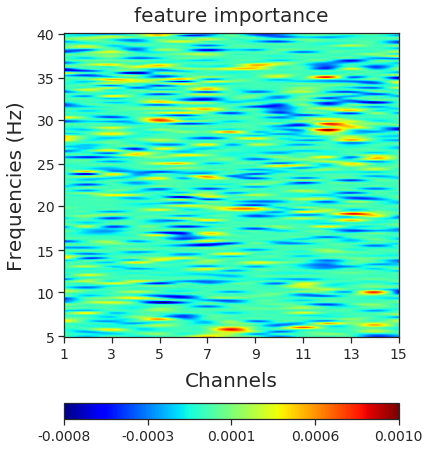

In [77]:
fig = plt.figure(figsize=(6, 8))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])

ax1, cbar1 = plot_spect(merged_perm_impvalues, ax = ax1, x = np.arange(0,15), y = cat_freqs_01, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)' , title = 'feature importance',
                 vmin = np.round(np.min(merged_perm_impvalues),5), 
                 vmax = np.round(np.max(merged_perm_impvalues),5), loc = 'bottom')

## earlysleep vs latesleep

In [78]:
compcategories = ['earlysleep', 'latesleep']

#['awake', 'sleep'] -- good perf, useful
#['presleep', 'earlysleep'] -- ok perf, useful
#['earlysleep', 'midsleep'] -- good perf, useful
#['latesleep', 'midsleep'] -- good perf, useful
#['earlysleep', 'latesleep'] -- bad perf, useful

In [79]:
features_df2 = features_df[features_df['state'].isin(compcategories)]
label_names = features_df2.state
classifierfeat_df = features_df2.copy()
classifierfeat_df = classifierfeat_df.drop(['start_time','end_time','depth','fly'], axis=1)

In [80]:
mergedperf_df, merged_ordered_cm, ordered_classes = computeclassfeats(compcategories)

results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
results loaded from disk..
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes are equal
encoder classes :  ['earlysleep' 'latesleep']
ordered classes :  ['latesleep' 'earlysleep']


In [81]:
mergedperf_df

,label,precision,recall,f1-score
0,earlysleep,0.452830,0.461538,0.457143
1,latesleep,0.461538,0.452830,0.457143
0,earlysleep,0.448980,0.415094,0.431373
1,latesleep,0.446429,0.480769,0.462963
0,earlysleep,0.465517,0.509434,0.486486
1,latesleep,0.446809,0.403846,0.424242
0,earlysleep,0.541667,0.490566,0.514851
1,latesleep,0.526316,0.576923,0.550459
0,earlysleep,0.470588,0.461538,0.466019
1,latesleep,0.481481,0.490566,0.485981


In [82]:
color_dict = dict({'awake':'#b34d4d',
                   'presleep':'#f2ad0d',
                   'earlysleep':'#1ac1e6',
                   'midsleep':'#0d28f2',
                   'latesleep':'#b3714d',
                   'sleep':'#0D28F2'
                  })

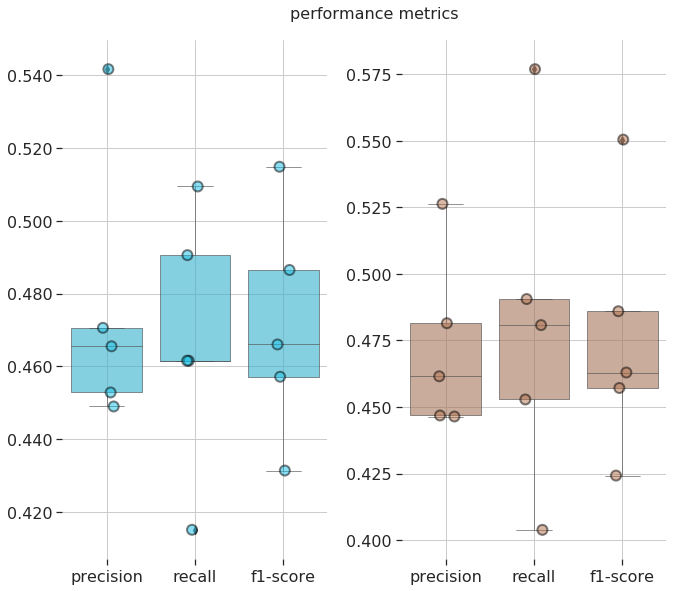

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24*2/5, 8))
fig.subplots_adjust(wspace=0.35, hspace=0.15)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, 
            color = color_dict[compcategories[0]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[0]], ax = ax1, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[0]], alpha = 0.5)

sns.boxplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, 
            color = color_dict[compcategories[1]],)
sns.stripplot(data=mergedperf_df[mergedperf_df['label']== compcategories[1]], ax = ax2, marker='o', linewidth=2, 
              edgecolor ="black", s= 10, color = color_dict[compcategories[1]], alpha = 0.5)

sns.despine(left=True, bottom = True)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)


ax1.grid(True)
ax2.grid(True)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))


ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.suptitle('performance metrics\n', x=0.55, y = 1.025, fontsize=label_fontsize)
plt.tight_layout()

In [84]:
print('Script started at: ' +  time.strftime('%X %x %Z'))

Script started at: 17:30:30 09/28/23 BST
